# Cross-Sections

UXarray allows for taking a cross-section along


In [99]:
import matplotlib.pyplot as plt
import numpy as np

import uxarray as ux

In [100]:
def set_lon_lat_xticks(ax, cross_section, n_ticks=6):
    """Utility function to draw stacked lat/lon points along the sampled cross-section"""
    da = cross_section

    N = da.sizes["steps"]
    tick_pos = np.linspace(0, N - 1, n_ticks, dtype=int)
    lons = da["lon"].values[tick_pos]
    lats = da["lat"].values[tick_pos]

    tick_labels = []
    for lon, lat in zip(lons, lats):
        lon_dir = "E" if lon >= 0 else "W"
        lat_dir = "N" if lat >= 0 else "S"
        tick_labels.append(f"{abs(lon):.2f}°{lon_dir}\n{abs(lat):.2f}°{lat_dir}")

    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_labels)

    ax.set_xlabel("Longitude / Latitude")
    plt.tight_layout()

    return fig, ax

In [101]:
grid_path = "../../test/meshfiles/scrip/ne30pg2/grid.nc"
data_path = "../../test/meshfiles/scrip/ne30pg2/data.nc"

uxds = ux.open_dataset(grid_path, data_path)
uxds["RELHUM"]

<xarray.UxDataArray 'RELHUM' (lev: 72, n_face: 21600)> Size: 6MB
[1555200 values with dtype=float32]
Coordinates:
  * lev      (lev) float64 576B 0.1238 0.1828 0.2699 ... 986.2 993.8 998.5
    time     object 8B ...
Dimensions without coordinates: n_face
Attributes:
    mdims:          1
    units:          percent
    long_name:      Relative humidity
    standard_name:  relative_humidity
    cell_methods:   time: mean

## Arbitrary Great Circle Arc (GCA)

In [117]:
start_point = (-45, -45)
end_point = (45, 45)

cross_section_gca = uxds["RELHUM"].cross_section(start=start_point, end=end_point)

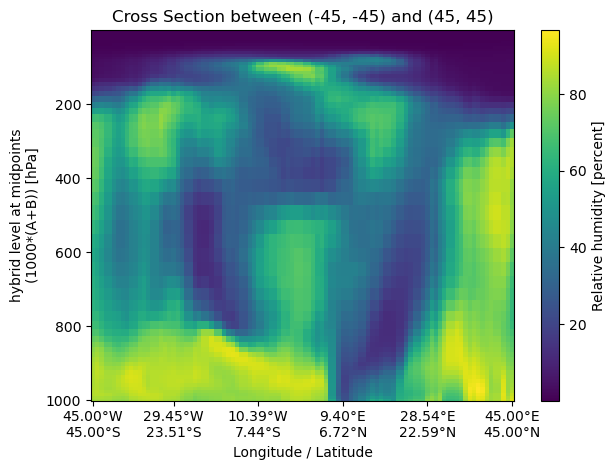

In [118]:
fig, ax = plt.subplots()
cross_section_gca.plot(ax=ax)

set_lon_lat_xticks(ax, cross_section_gca)
ax.set_title(f"Cross Section between {start_point} and {end_point}")
ax.invert_yaxis()

## Constant Latitude

In [119]:
lat = 45
cross_section_const_lat = uxds["RELHUM"].cross_section(lat=lat)

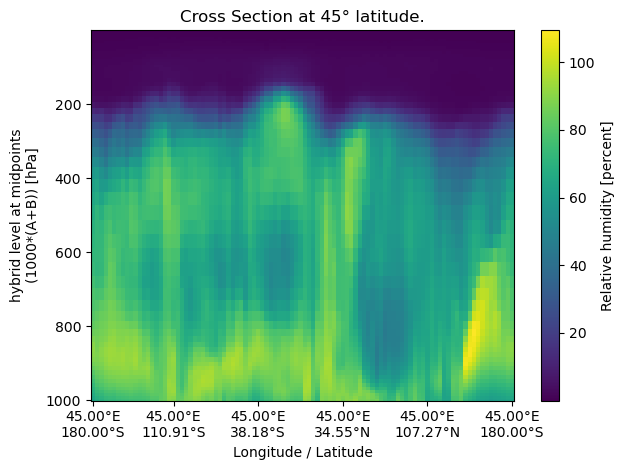

In [120]:
fig, ax = plt.subplots()
cross_section_const_lat.plot(ax=ax)

set_lon_lat_xticks(ax, cross_section_const_lat)
ax.set_title(f"Cross Section at {lat}° latitude.")
ax.invert_yaxis()

## Constant Longitude

In [121]:
lon = 0
cross_section_const_lon = uxds["RELHUM"].cross_section(lon=lon)

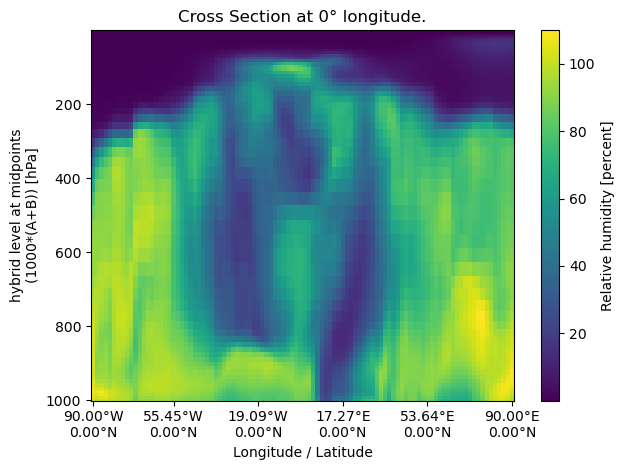

In [122]:
fig, ax = plt.subplots()
cross_section_const_lon.plot(ax=ax)

set_lon_lat_xticks(ax, cross_section_const_lon)
ax.set_title(f"Cross Section at {lon}° longitude.")
ax.invert_yaxis()